<a href="https://colab.research.google.com/github/daiqing2009/CP640/blob/main/project/code/EE_intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
The goal of this project to measure the effectiveness of common machine learning techniques in differentiating malicious traffic from benign one and identifying corresponding attacks categories and sub-categories. Meanwhile, the project will challenge the requirement to detect the intrusion traffic efficiently as required in real-world situations, especially how models trained on small data perform on larger data.
* Effective Machine Learning
    * Import isproportional Data sampling
    * EDA & Preprocessing
    * Model Selection and Evaluation
* Efficient Machine Learning
    * Model performance on different scale of sampling data
    * Potential integration with IPS(Intrusion Prevention System)


# Effective Machine Learning
In this section, dataaset will be imported. Then Exploratory Data Analysis(EDA) and corresponding preprocessing will conducted before model training and evaluation.

In [46]:
import sklearn as sk
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

RANDOM_STATE = 42
# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns]:
    print(f"Using {lib.__name__} {lib.__version__}")

# define the thresthold for proprocessors
VAR_THR = 0.03
CORR_THR = 0.9


Using pandas 2.2.2
Using sklearn 1.5.2
Using seaborn 0.13.2


## Importing Data
The importing subsection try to be competible in all environments, including Colab, Kaggle and local dev. The original dataset is on https://www.kaggle.com/datasets/daiqing2009/ciciot2023-disprop-sampling

In [47]:
import os
import subprocess

def detect_environment():
    """Detects the environment: Kaggle, Google Colab, or Local."""
    if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        return "Kaggle"
    elif "COLAB_GPU" in os.environ:
        return "Google Colab"
    else:
        return "Local"

def create_folder_if_not_exists(path):
    """Creates a folder if it does not already exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Folder created at: {path}")
    else:
        print(f"Folder already exists at: {path}")

def setup_kaggle_credentials():
    """Ensures Kaggle API credentials are available."""
    if detect_environment() == "Google Colab":
      from google.colab import userdata
      os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
      os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    elif detect_environment() == "Local":
      kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
      if not os.path.exists(kaggle_json_path):
        # Prompt user to upload `kaggle.json`
        print("Please upload your `kaggle.json` file.")
        from google.colab import files
        uploaded = files.upload()
        with open(kaggle_json_path, "wb") as f:
            f.write(uploaded['kaggle.json'])
      os.chmod(kaggle_json_path, 0o600)  # Set correct permissions for the file

def download_kaggle_resource(input_path, resource_name):
    """
    Downloads a dataset or notebook output from Kaggle using the resource name.
    Automatically unzips if needed and logs useful diagnostic information.
    """
    from kaggle.api.kaggle_api_extended import KaggleApi
    import os

    setup_kaggle_credentials()

    # Initialize Kaggle API
    api = KaggleApi()
    api.authenticate()

    try:
        # Attempt to download as a dataset
        print(f"Attempting to download dataset: {resource_name}")
        api.dataset_download_files(resource_name, path=input_path, unzip=True)
        print(f"Dataset downloaded and extracted to {input_path}")
    except Exception as dataset_error:
        print(f"Dataset not found or inaccessible: {dataset_error}. Attempting as notebook output.")
        try:
            # Attempt to download as notebook output
            print(f"Attempting to download notebook output: {resource_name}")
            api.kernel_output(resource_name, path=input_path, unzip=True)
            print(f"Notebook output downloaded and extracted to {input_path}")
        except Exception as notebook_error:
            print(f"Failed to download resource: {resource_name}.")
            print(f"Dataset error: {dataset_error}")
            print(f"Notebook output error: {notebook_error}")
            print("Please verify the resource name, access permissions, and your Kaggle API credentials.")

# Step 1: Detect environment
environment = detect_environment()
print(f"Environment detected: {environment}")

# Step 2: Create input folder
if environment == "Kaggle":
    input_path = "/kaggle/input"
elif environment == "Google Colab":
    input_path = "/content/input"
elif environment == "Local":
    input_path = "./input"
else:
    raise ValueError("Unknown environment detected!")

create_folder_if_not_exists(input_path)
print(f"Input folder path: {input_path}")

# Step 3: Create output folder
if environment == "Kaggle":
    output_path = "/kaggle/working/output"
elif environment == "Google Colab":
    output_path = "/content/output"
elif environment == "Local":
    output_path = "./output"
else:
    raise ValueError("Unknown environment detected!")

create_folder_if_not_exists(output_path)
print(f"Output folder path: {output_path}")

# Step 4: Download dataset or notebook output
if environment != "Kaggle":
    # resource_name = input("Enter the Kaggle dataset name or notebook name to download: ")
    resource_name = "daiqing2009/ciciot2023-disprop-sampling"
    download_kaggle_resource(input_path, resource_name)

# initialize the data prefix
if environment == "Kaggle":
    dataprefix = input_path + "/" + resource_name.split("/")[1]
elif environment == "Google Colab":
    dataprefix = input_path
elif environment == "Local":
    dataprefix = input_path

Environment detected: Google Colab
Folder already exists at: /content/input
Input folder path: /content/input
Folder already exists at: /content/output
Output folder path: /content/output
Attempting to download dataset: daiqing2009/ciciot2023-disprop-sampling
Dataset URL: https://www.kaggle.com/datasets/daiqing2009/ciciot2023-disprop-sampling
Dataset downloaded and extracted to /content/input


In [48]:
if environment == "Google Colab":
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# 0.1 percent as size xs
df2_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_2classes.csv")
df8_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_8classes.csv")
df34_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_34classes.csv")

# 0.5 percent as size s
df2_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_2classes.csv")
df8_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_8classes.csv")
df34_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_34classes.csv")

# 1 percent as size m
# df2_m = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.01_dist_percent_2classes.csv")
df8_m = pd.read_csv(f"{dataprefix}/0.01_dist_percent_8classes.csv")
# df34_m = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.01_dist_percent_34classes.csv")

In [50]:
# setting the default dataset
df2 = df2_xs
df8 = df8_xs
df34 = df34_xs

In [51]:
# extract the label value
label2=df2["benign"]
df2 = df2.drop("benign", axis=1)
label8=df8["label"]
df8 = df8.drop("label", axis=1)
label34=df34["label"]
df34 = df34.drop("label", axis=1)

## EDA & Preprocessing
**Summary Table of EDA Methods and Preprocessing**
Following table is a brief summary of common Exploratory Data Analysis (EDA) and corresponding Preprocessing methods.

| EDA Method|Typical Preprocessing/Feature Engineering|Relevancy to current probelm|
|--|--|--|
|Data Cleaning|Handle missing values, duplicates, and outliers.|outlier is the challenge of the dataset, capping techniques are applied to |
|Univariate Analysis|Normalize/encode features, transform skewed data.|show skewness of the data and visualize with histogram, boxplot, drop column with limited info|
|Multivariate Analysis|Normalize, reduce multicollinearity, apply dimensionality reduction.|show Correlation table and reduce dimension with PCA/t-CNS|
|Target Variable Analysis|Balance classes, transform skewed distributions.|the label class is highly biased , espcially for (D)DOS. Dispropotional Sampling is used to balance class |
|Time Series Analysis|Interpolate missing data, extract date/time features, apply smoothing.|N/A, since the dataset is already engineered and temporal information has been compacted|
The preprocessing will be conducted in following steps:


1. OneHotEncoding for categorical features.
2. Drop features of both low variance and low correlation with target label.
3. Drop highly correlated features
4. Reduce dimension Using PCA

Finally, all these steps are pipelined using scikit learn functions.



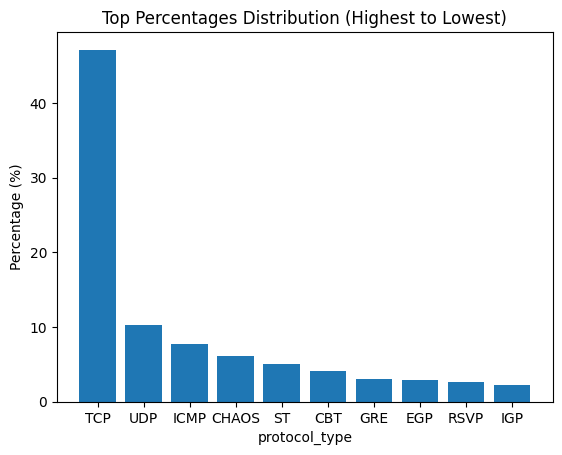

Top 20 Percentages (from Highest to Lowest):
protocol_type
TCP                   47.130530
UDP                   10.242889
ICMP                   7.736383
CHAOS                  6.051682
ST                     5.001598
CBT                    4.070219
GRE                    2.958499
EGP                    2.919691
RSVP                   2.563576
IGP                    2.271378
BBN-RCC-MON            1.435876
XNET                   1.050084
PUP                    1.031822
NVP-II                 1.018125
ARGUS (deprecated)     0.856047
IDRP                   0.849199
HOPOPT                 0.652879
EMCON                  0.641465
IPv4                   0.470255
IPv6-Frag              0.264804
Name: proportion, dtype: float64


In [52]:
# Calculate percentages for each unique value
value_counts = df2['protocol_type'].value_counts(normalize=True) * 100

# Sort percentages from highest to lowest
sorted_percentages = value_counts.sort_values(ascending=False)

# Get top 10 percentages (or fewer if there are less than unique values)
top_percentages = sorted_percentages.head(10)

# Plot histogram for the top values sorted by percentage
plt.bar(top_percentages.index, top_percentages.values)
plt.title("Top Percentages Distribution (Highest to Lowest)")
plt.xlabel("protocol_type")
plt.ylabel("Percentage (%)")
plt.xticks(top_percentages.index)  # Ensure x-axis labels show only top values
plt.show()

# Print the top sorted percentages
print("Top 20 Percentages (from Highest to Lowest):")
print(sorted_percentages[:20])

In [53]:
# Step 1: OneHotEncoding for categorical features
categorical_features = ['protocol_type']
categorical_transformer = OneHotEncoder(sparse_output=False)
encoded_categorical = categorical_transformer.fit_transform(df2[categorical_features])
# print(encoded_categorical)

# Create a DataFrame for the encoded categorical features
encoded_df = pd.DataFrame(encoded_categorical, columns=categorical_transformer.get_feature_names_out(categorical_features))

# Drop the original categorical columns and concatenate the encoded features
df2_filtered = df2.drop(categorical_features, axis=1)
df2_filtered = pd.concat([df2_filtered, encoded_df], axis=1)
df2_filtered.head()

,flow_duration,header_length,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,protocol_type_RSVP,protocol_type_SDRP,protocol_type_ST,protocol_type_TCP,protocol_type_TP++,protocol_type_TRUNK-1,protocol_type_TRUNK-2,protocol_type_UDP,protocol_type_XNET,protocol_type_XTP
0,1.828260,171,64.00,1,1,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.094752,60,65.91,2,2,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.775582,583305,63.60,101,101,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.488923,3754787,63.85,2722,2722,0.0,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.264529,132935,47.00,113,113,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
onehot_cols = ['http','https','dns','telnet','smtp','ssh','irc','tcp','udp','dhcp','arp','icmp','ipv','llc']
onehot_cols.extend(encoded_df.columns.tolist())
# print(f'onehot_cols:{onehot_cols}')
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    """Calculate Cramér's V for a contingency table."""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def filter_strong_association_features(df, target, threshold=0.3):
    """
    Filter binary/categorical features strongly associated with a categorical target label.

    Parameters:
        df (pd.DataFrame): DataFrame containing features and the target label.
        target_col (str): Name of the categorical target label column.
        threshold (float): Minimum Cramér's V value to consider a strong association.

    Returns:
        list: List of feature names with strong association.
    """
    strong_features = []

    # Loop through features in the DataFrame
    for col in df.columns:
        # if col == target_col:  # Skip the target column
        #     continue
        if df[col].nunique() <= 10:  # Check if the column is categorical/binary
            # Create a contingency table
            contingency_table = pd.crosstab(df[col], target)

            # Calculate Cramér's V
            cramer_v_value = cramers_v(contingency_table)

            # If Cramér's V exceeds the threshold, consider it strongly associated
            if cramer_v_value >= threshold:
                strong_features.append(col)

    return strong_features

cols_valueable = filter_strong_association_features(df2_filtered,label34, threshold=0.3)
print(f'cols_valueable in onehotcode:{cols_valueable}')

<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
<ipython-input-54-5953eab16d35>:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


cols_valueable in onehotcode:['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'fin_count', 'http', 'https', 'ssh', 'tcp', 'udp', 'icmp', 'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP', 'protocol_type_GRE', 'protocol_type_ICMP', 'protocol_type_IDRP', 'protocol_type_RSVP', 'protocol_type_TCP', 'protocol_type_UDP']


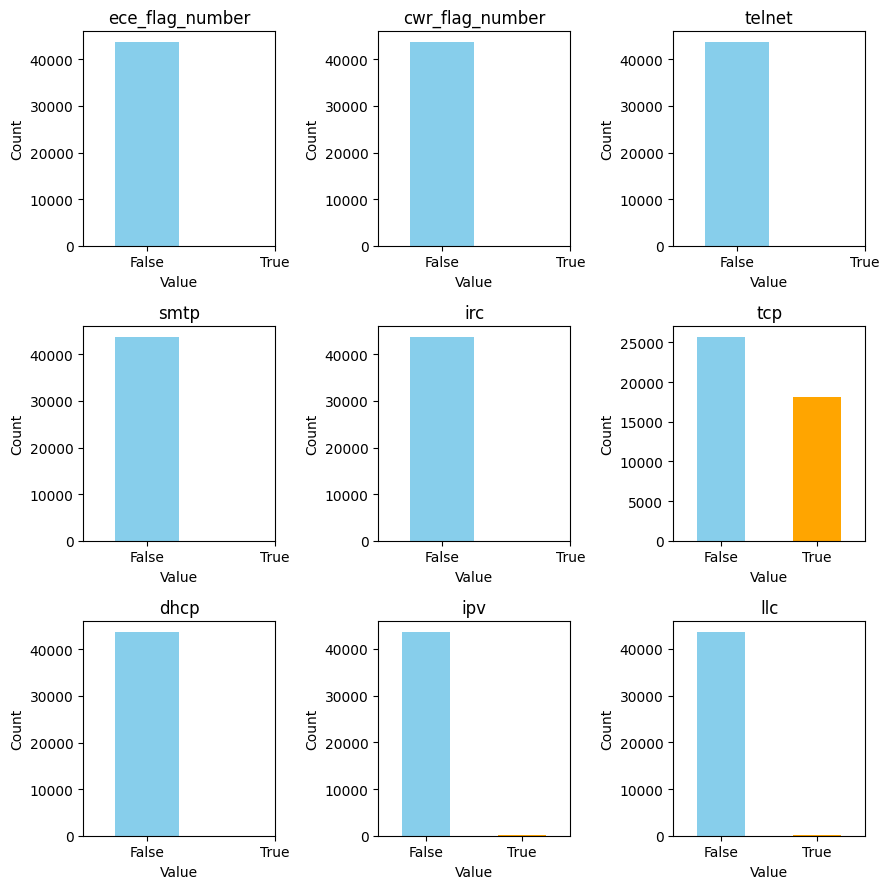

In [55]:
# filter out columns with uniform distribution(always the same value)
skewness = df2_filtered.skew()
# print(skewness)

df2_ls = df2_filtered.loc[:,skewness<0.00001]

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each column's histogram in the corresponding subplot
for i, column in enumerate(df2_ls.columns):
    # Count the occurrences of True and False
    value_counts = df2_ls[column].value_counts()
    # Plot the histogram
    value_counts.plot(kind='bar', color=['skyblue', 'orange'], ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

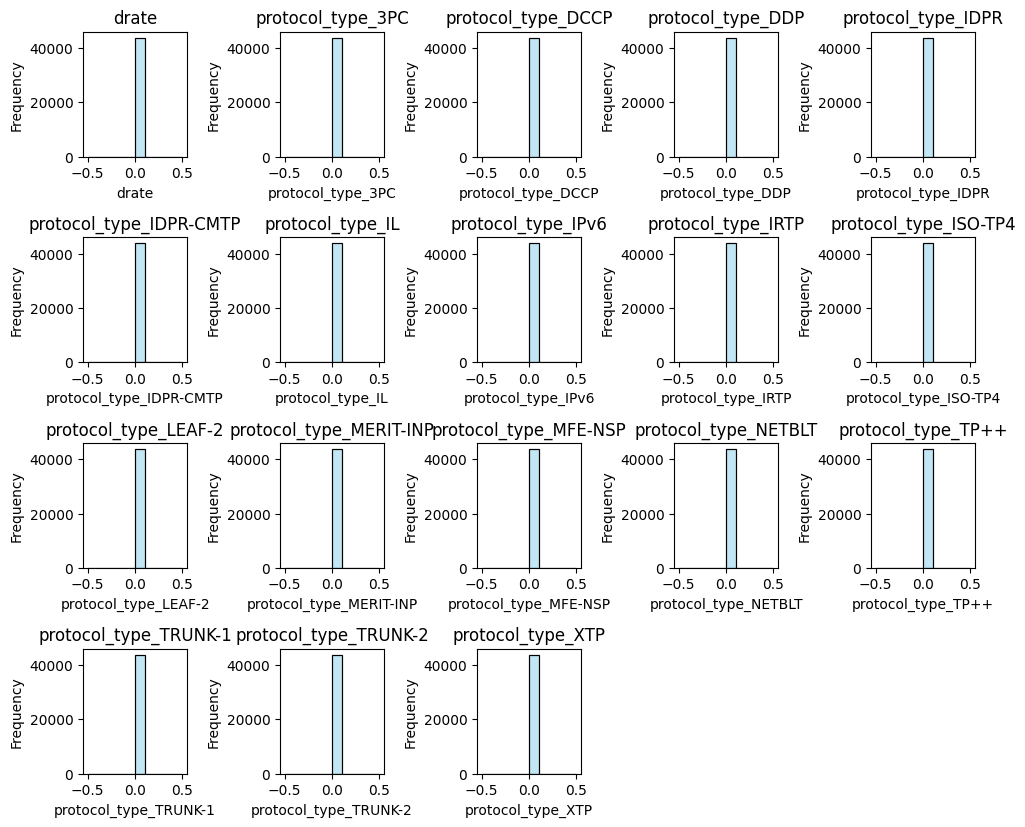

In [56]:
# analyze the colunmn with high abs skew values
df2_hs = df2_filtered.loc[:,abs(skewness)>50]

# print(df2_hs.head(10))

# # Identify continuous columns (e.g., numeric columns)
continuous_columns = df2_hs.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting
plt.figure(figsize=(10, 10))

# delete columns with too high skewness
from scipy.stats import mstats

df_winsorized = df2_hs[continuous_columns].apply(lambda x: mstats.winsorize(x, limits=[0.05, 0.05]))

# Loop through continuous columns and plot histograms
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(5,5, i)
    sns.histplot(df_winsorized[col], kde=True, bins=10, color='skyblue', edgecolor='black')  # histogram with KDE
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [57]:
# Step 2: drop features of both low variance and low correlation with target label.
var_thr = VarianceThreshold(threshold = VAR_THR) #Removing both constant and quasi-constant
var_thr.fit(df2_filtered)

var_thr.get_support()
concol = [column for column in df2_filtered.columns
          if column not in df2_filtered.columns[var_thr.get_support()]]
print(f'columns of low variance: {concol}')

columns of low variance: ['drate', 'ece_flag_number', 'cwr_flag_number', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'dhcp', 'arp', 'ipv', 'llc', 'protocol_type_3PC', 'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON', 'protocol_type_DCCP', 'protocol_type_DDP', 'protocol_type_EGP', 'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_GRE', 'protocol_type_HOPOPT', 'protocol_type_IDPR', 'protocol_type_IDPR-CMTP', 'protocol_type_IDRP', 'protocol_type_IGMP', 'protocol_type_IGP', 'protocol_type_IL', 'protocol_type_IPv4', 'protocol_type_IPv6', 'protocol_type_IPv6-Frag', 'protocol_type_IPv6-Route', 'protocol_type_IRTP', 'protocol_type_ISO-TP4', 'protocol_type_LEAF-2', 'protocol_type_MERIT-INP', 'protocol_type_MFE-NSP', 'protocol_type_NETBLT', 'protocol_type_NVP-II', 'protocol_type_PUP', 'protocol_type_RSVP', 'protocol_type_SDRP', 'protocol_type_TP++', 'protocol_type_TRUNK-1', 'protocol_type_TRUNK-2', 'protocol_type_XNET', 'protocol_type_XTP']


In [58]:
# remove the feature of both low variance and low
cols_to_drop = [col for col in concol if col not in cols_valueable]
print(f'cols_to_drop: {cols_to_drop}')
df2_normal = df2_filtered.drop(concol,axis =1)
df2_normal.head()

cols_to_drop: ['drate', 'ece_flag_number', 'cwr_flag_number', 'dns', 'telnet', 'smtp', 'irc', 'dhcp', 'arp', 'ipv', 'llc', 'protocol_type_3PC', 'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON', 'protocol_type_DCCP', 'protocol_type_DDP', 'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT', 'protocol_type_IDPR', 'protocol_type_IDPR-CMTP', 'protocol_type_IGMP', 'protocol_type_IGP', 'protocol_type_IL', 'protocol_type_IPv4', 'protocol_type_IPv6', 'protocol_type_IPv6-Frag', 'protocol_type_IPv6-Route', 'protocol_type_IRTP', 'protocol_type_ISO-TP4', 'protocol_type_LEAF-2', 'protocol_type_MERIT-INP', 'protocol_type_MFE-NSP', 'protocol_type_NETBLT', 'protocol_type_NVP-II', 'protocol_type_PUP', 'protocol_type_SDRP', 'protocol_type_TP++', 'protocol_type_TRUNK-1', 'protocol_type_TRUNK-2', 'protocol_type_XNET', 'protocol_type_XTP']


,flow_duration,header_length,duration,rate,srate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,...,covariance,variance,weight,magnitude,protocol_type_CBT,protocol_type_CHAOS,protocol_type_ICMP,protocol_type_ST,protocol_type_TCP,protocol_type_UDP
0,1.828260,171,64.00,1,1,False,True,False,False,False,...,0.000000e+00,0.00,141.55,10.392304,0.0,0.0,0.0,0.0,1.0,0.0
1,0.094752,60,65.91,2,2,False,True,False,False,False,...,1.682124e+02,0.19,141.55,10.495475,0.0,0.0,0.0,0.0,1.0,0.0
2,13.775582,583305,63.60,101,101,False,False,False,False,True,...,2.296891e+07,0.90,38.50,101.073670,0.0,0.0,0.0,0.0,1.0,0.0
3,2.488923,3754787,63.85,2722,2722,False,False,False,False,False,...,4.247406e+02,0.08,141.55,33.241130,0.0,0.0,0.0,0.0,0.0,1.0
4,1.264529,132935,47.00,113,113,False,False,False,False,True,...,0.000000e+00,0.00,38.50,11.489125,0.0,0.0,0.0,0.0,1.0,0.0


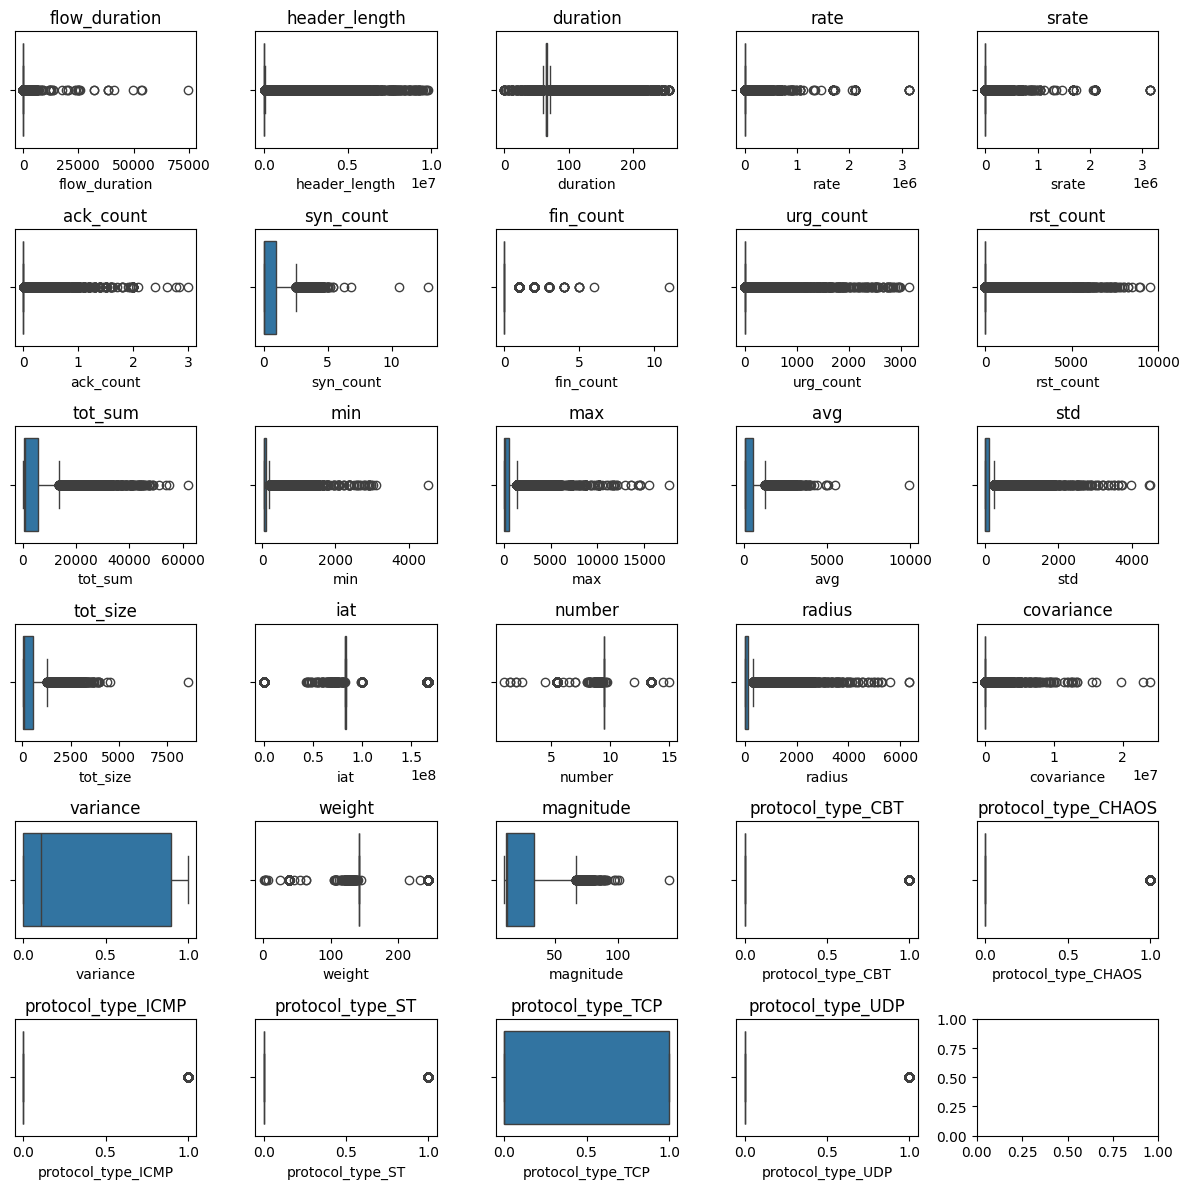

In [59]:
# show boxplot of parameter with comparatively normal distribution
continuous_columns = df2_normal.select_dtypes(include=['float64', 'int64']).columns

# Create a grid for the boxplots
fig, axes = plt.subplots(6, 5, figsize=(12, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(continuous_columns):
    sns.boxplot(x=df2_normal[col], ax=axes[i])
    axes[i].set_title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

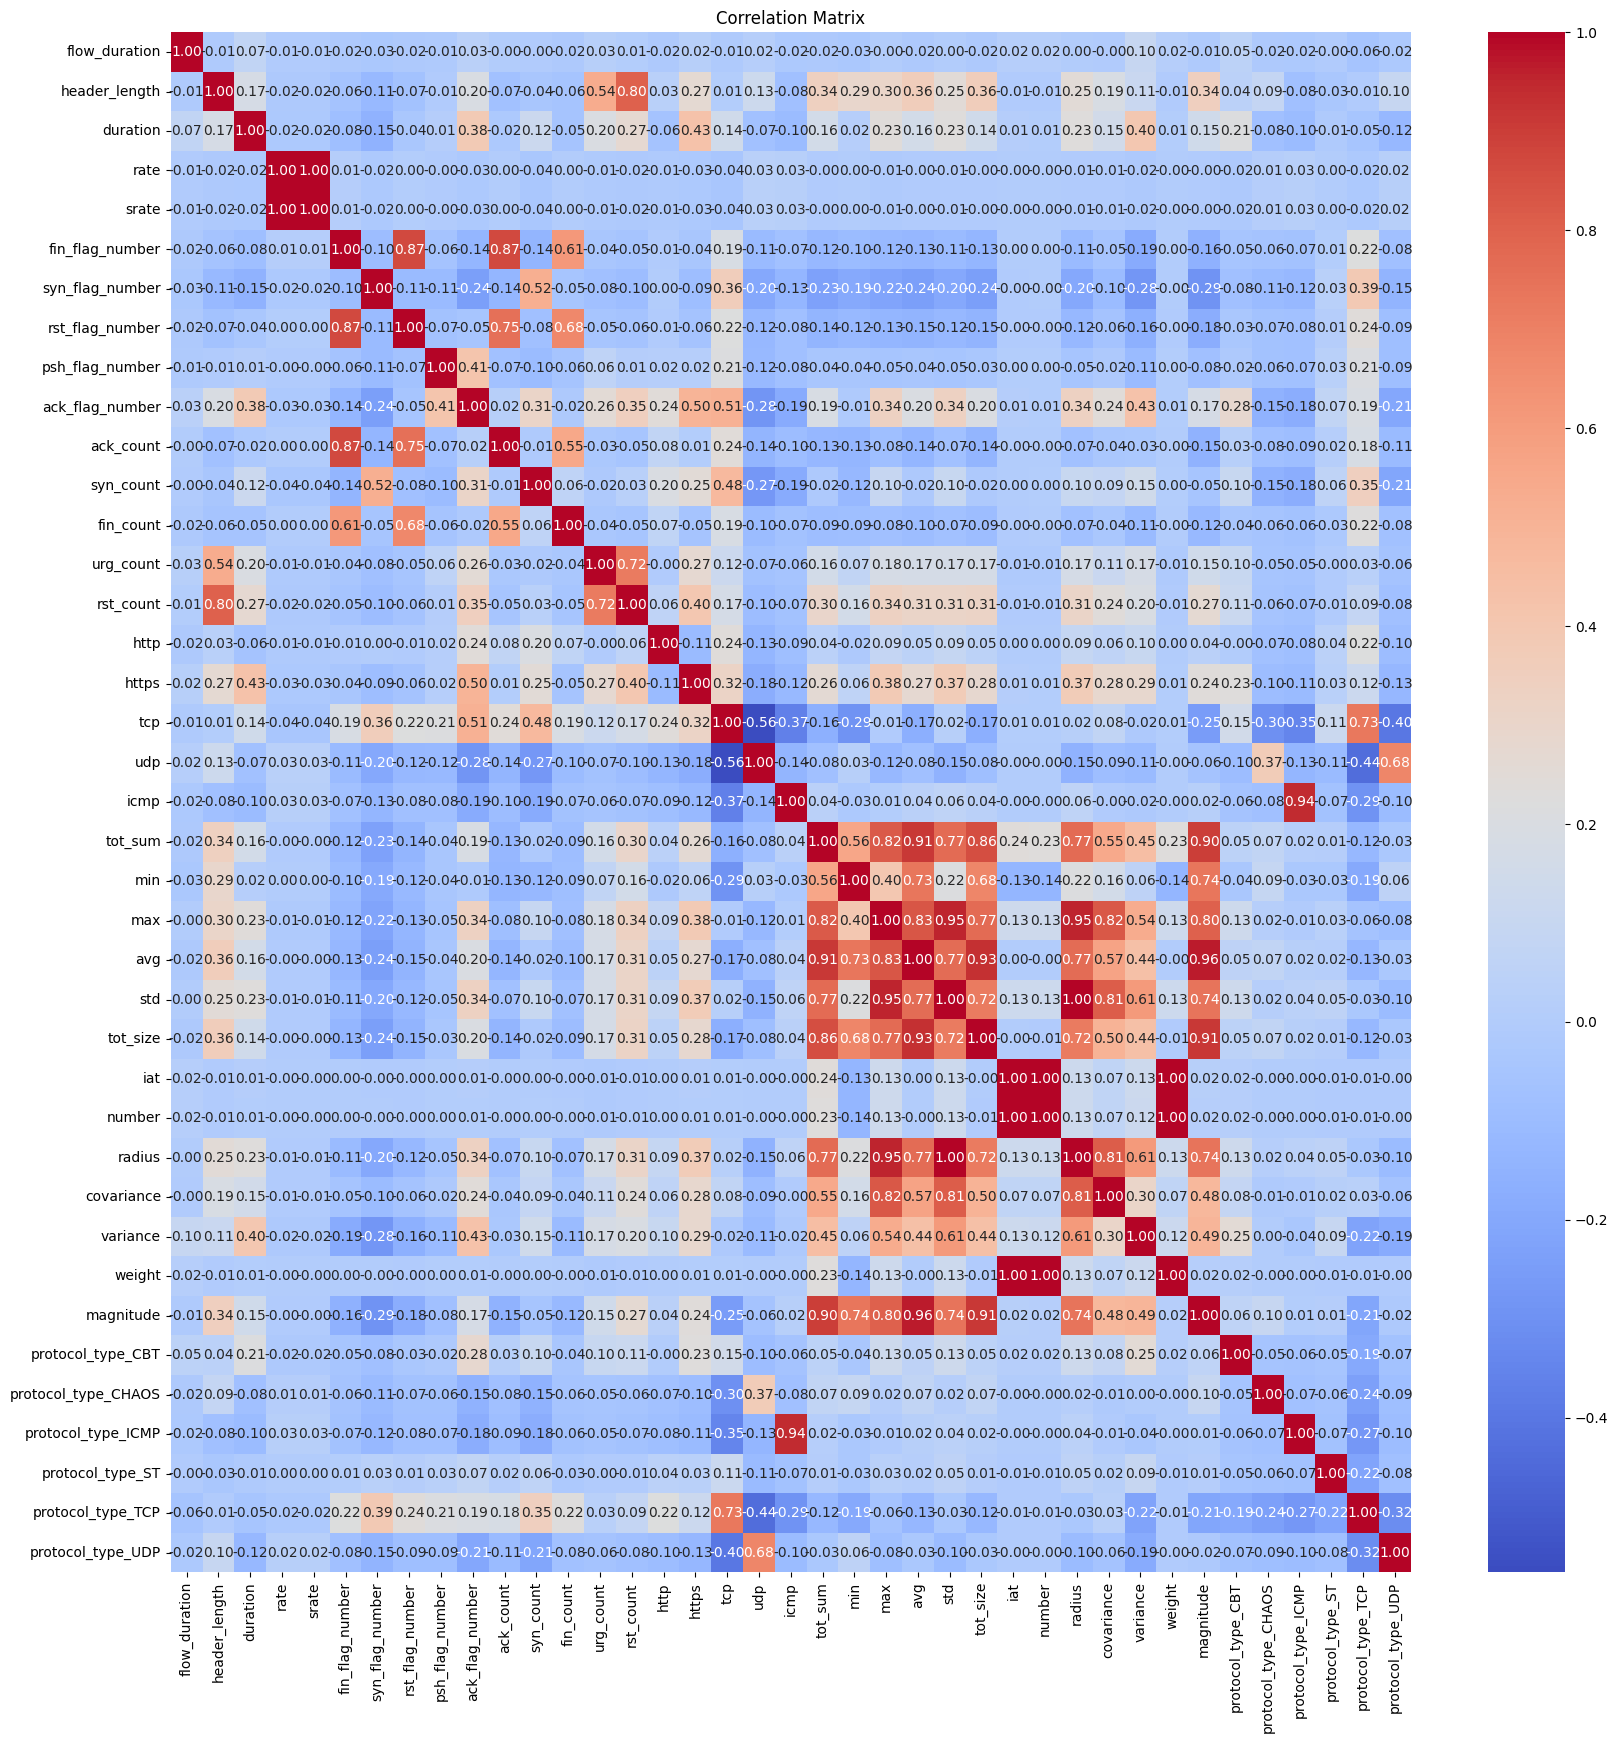

In [60]:
# Correlation Analysis
def show_corr(df):
    corr_matrix = df.corr()

    # Visualize the correlation matrix

    plt.figure(figsize=(20, 20))

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xticks(rotation=90)
    plt.title('Correlation Matrix')
    plt.show()
show_corr(df2_normal)

In [61]:
# Step 3: Drop highly correlated features
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)

        # Compute the correlation matrix
        corr_matrix = X.corr().abs()

        # Identify highly correlated features
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.threshold)]
        print(f'column of high correlation({self.threshold}) to be dropped: {self.to_drop_}')
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)

        # Drop identified columns
        return X.drop(columns=self.to_drop_, errors='ignore')

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
df_reduced = CorrelationFilter(threshold=CORR_THR).fit_transform(df2_normal)
# df_reduced = CorrelationFilter(threshold=0.9).fit_transform(df2_normal)

column of high correlation(0.9) to be dropped: ['srate', 'avg', 'std', 'tot_size', 'number', 'radius', 'weight', 'magnitude', 'protocol_type_ICMP']


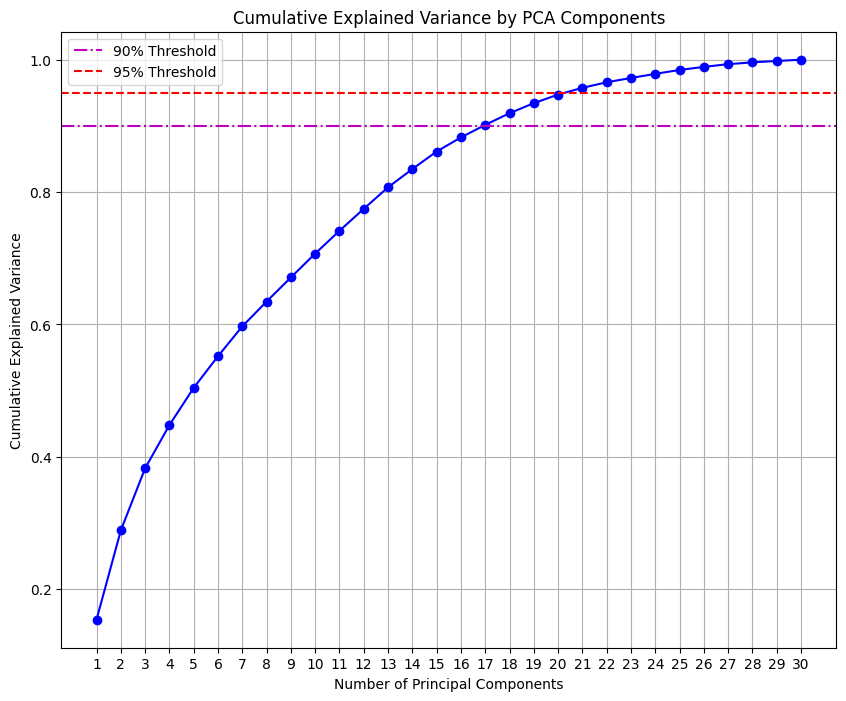

In [62]:
# Step4:reduce dimension Using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def CumuPlot(df):
    # Apply PCA with the adjusted number of components
    pca = PCA()

    df_pca = pca.fit_transform(df)

    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.axhline(y=0.90, color='m', linestyle='-.', label='90% Threshold')  # Optional threshold line
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')  # Optional threshold line
    plt.xticks(range(1, len(cumulative_variance) + 1))  # Ensure x-ticks align with components
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.legend()
    plt.grid()
    plt.show()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_reduced)
CumuPlot(df_scaled)

In [63]:
# Apply PCA and retain the top n components
n_components = 20 #take 95% variance as target
pca = PCA(n_components=n_components)

df_scaled = pd.DataFrame(df_scaled)
principal_components = pca.fit_transform(df_scaled)

# print(scaler.fit_transform(principal_components)[:5])

# Get PCA components (loadings)
components = pca.components_

df = df_reduced
# Compute the importance of each feature
importance = components.T  # Transpose to make features the rows
importance_scores = pd.DataFrame(importance, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=df.columns)

# Calculate the total contribution of each feature across all PCs
top_n = 20  # Change this to the desired number of features
importance_scores['Total'] = (importance_scores.abs() * pca.explained_variance_ratio_).sum(axis=1)
print(f"Top({top_n}) features of  importance: ")
print(importance_scores['Total'].sort_values(ascending=False).head(top_n))

Top(20) features of  importance: 
min                    0.149124
variance               0.142165
syn_count              0.141347
protocol_type_UDP      0.136027
https                  0.135405
udp                    0.134880
covariance             0.134648
syn_flag_number        0.133966
tot_sum                0.133623
ack_flag_number        0.130849
icmp                   0.130800
max                    0.129055
header_length          0.128817
duration               0.128264
http                   0.126835
psh_flag_number        0.126597
protocol_type_TCP      0.125971
urg_count              0.125530
rst_count              0.122548
protocol_type_CHAOS    0.121404
Name: Total, dtype: float64


In [64]:
# build up pipeline for structured preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# determine categorical and numerical features
numerical_feature = df2.select_dtypes(include=['int64', 'float64']).columns
# categorical_ix = df2.select_dtypes(include=['object', 'bool']).columns

# Preprocessing for numeric and categorical features
label_cols = ["benign","label"]
skip_cols = categorical_features + label_cols
pass_cols = [col for col in df2.columns if col not in skip_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ],remainder='passthrough')

# Create the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance_filter", VarianceThreshold(threshold = VAR_THR)),
    ("correlation_filter", CorrelationFilter(threshold=CORR_THR)),
    ("scaler", StandardScaler()),
    ("pca", pca)
])

## Models Selection & Evaluation
|Model|Type|Advantage|
|--|--|--|
|Logistic Regression|Supervised  |Easy to implement, computational efficient|
|KNN               |Supervised  |widely-used for classification of known number(k) of clusters, can upgrade to outlier robust variant: DBSCAN|
|Random Forest     |Supervised|Ensemble decision trees, robust to skewness of data|
|Auto-encoder      |Unsupervised|Deep Learning model for abnormal detection, which only differentiate benign and attack flow|

Supervised models will be trained and evaluated on 0.1 percent data in classifying 2/8/34 traffic category, including Benign and Attacking case.

In [65]:
def split(df,label = "label"):

    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]

    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)

    # return X_train, X_test, y_train, y_test
    return scaled_X_train, scaled_X_test, y_train, y_test

In [66]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "KNN", "Random Forest"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

In [67]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [68]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, X_test, y_test, target_names, classes, model_name):
    pred = model.predict(X_test)

    # print(pred[:5])
    # print(f'y_test.type:{type(y_test)}.shape:{y_test.shape} & y_test.type:{type(pred)}.shape:{pred.shape}')
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    print(classification_report(y_test, pred, digits = 3))

    if classes == 2 or classes == 8:
        plt.figure(figsize = (4, 2), dpi = 300)
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                               display_labels = target_names).plot()
        plt.title(model_name)
        plt.xticks(rotation=30);

In [69]:
# save and load models for testing on different percentage of data
!mkdir models
def pickle_save(model, name):
    model_filename = 'models/' + name + '.pkl'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)

    print(f"Model saved to {name}")

def pickle_load(name):
    model_filename = 'models/' + name + '.pkl'
    try:
        with open(model_filename, 'rb') as model_file:
            model = pickle.load(model_file)
        print(f"Model loaded from {model_filename}")
        return model
    except FileNotFoundError:
        print(f"Error: The file '{model_filename}' does not exist.")
        return None
    except pickle.UnpicklingError:
        print(f"Error: Failed to load the model from '{model_filename}'. The file might be corrupted.")
        return None

mkdir: cannot create directory ‘models’: File exists


In [70]:
# print(df2_xs)
df_processed = pd.DataFrame(pipeline.fit_transform(df2))
# df_processed = pd.DataFrame(pca.fit_transform(df_reduced))
# df_processed = pd.read_csv("/kaggle/input/pca-transformed/pca_transformed_data_v11.csv")
# print(df_pca.head())
print(df_processed.shape)
df_processed["label"] = label2
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Attack", "Benign"]
# print(label2.head())

column of high correlation(0.9) to be dropped: [10, 25, 29, 30, 31, 33, 34, 37, 38]
(43806, 20)


              precision    recall  f1-score   support

       False      0.969     0.992     0.980      8435
        True      0.476     0.180     0.262       327

    accuracy                          0.962      8762
   macro avg      0.722     0.586     0.621      8762
weighted avg      0.951     0.962     0.954      8762

Model saved to logreg_2


<Figure size 1200x600 with 0 Axes>

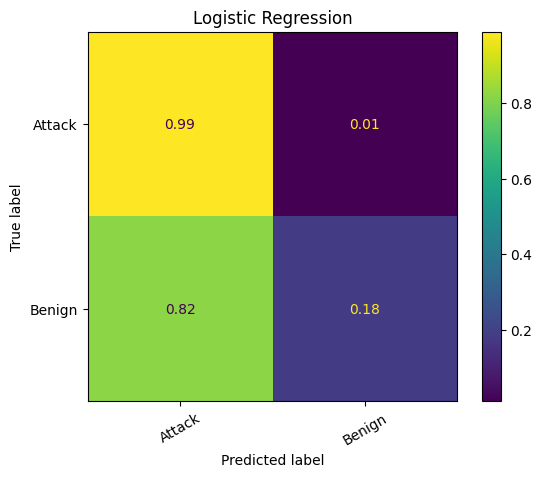

In [71]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 2, "Logistic Regression")
pickle_save(logreg_model, "logreg_2")

              precision    recall  f1-score   support

       False      0.971     0.994     0.982      8435
        True      0.587     0.226     0.327       327

    accuracy                          0.965      8762
   macro avg      0.779     0.610     0.654      8762
weighted avg      0.956     0.965     0.958      8762

Model saved to knn_2


<Figure size 1200x600 with 0 Axes>

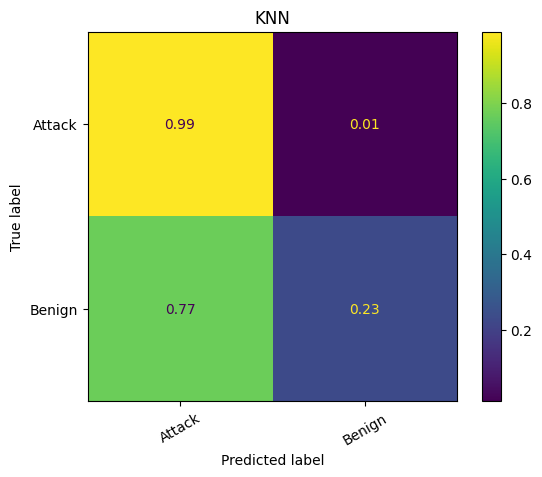

In [72]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 2, "KNN")
pickle_save(knn, "knn_2")

              precision    recall  f1-score   support

       False      0.973     0.993     0.983      8435
        True      0.610     0.287     0.391       327

    accuracy                          0.967      8762
   macro avg      0.792     0.640     0.687      8762
weighted avg      0.959     0.967     0.961      8762

Model saved to rfc_2


<Figure size 1200x600 with 0 Axes>

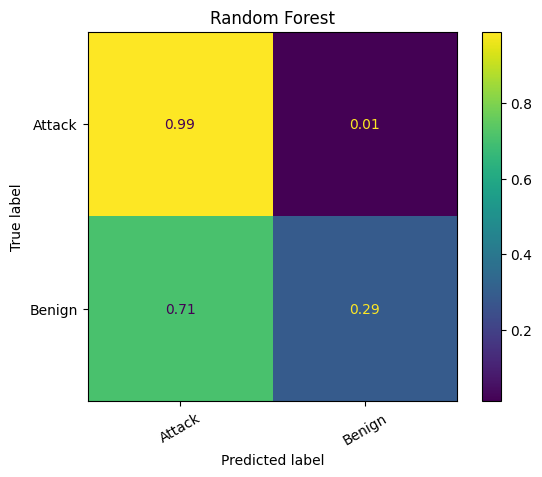

In [73]:
# Weight-balanced
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 2, "Random Forest")
pickle_save(rfc, "rfc_2")

In [74]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv(f'{output_path}/metrics_2.csv', index=True)
metrics_2

,Logistic Regression,KNN,Random Forest
Accuracy,0.961995,0.965191,0.96656
Recall,0.586361,0.610067,0.640174
Precision,0.72239,0.779003,0.791661
F1-Score,0.621068,0.654422,0.68683


### 8 Classes

In [75]:
# df8_feat = pd.read_csv('/kaggle/working/pca_transformed_data.csv')
# df_processed = pd.DataFrame(pca.fit_transform(df_reduced))
# df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label']=label8
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)

              precision    recall  f1-score   support

      Benign      0.425     0.422     0.423       327
  BruteForce      0.333     0.008     0.016       122
        DDoS      0.719     0.945     0.817      4150
         DoS      0.582     0.115     0.192      1361
       Mirai      0.980     0.987     0.984       938
       Recon      0.491     0.575     0.530       835
    Spoofing      0.580     0.452     0.508       471
         Web      0.480     0.364     0.414       558

    accuracy                          0.689      8762
   macro avg      0.574     0.483     0.485      8762
weighted avg      0.665     0.689     0.642      8762

Model saved to logreg_8


<Figure size 1200x600 with 0 Axes>

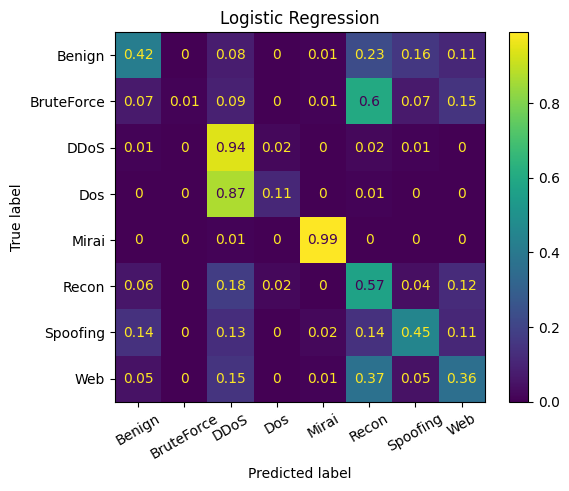

In [76]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 8, "Logistic Regression")
pickle_save(logreg_model, "logreg_8")

              precision    recall  f1-score   support

      Benign      0.450     0.477     0.463       327
  BruteForce      0.280     0.172     0.213       122
        DDoS      0.913     0.716     0.803      4150
         DoS      0.486     0.807     0.607      1361
       Mirai      0.999     0.987     0.993       938
       Recon      0.614     0.666     0.639       835
    Spoofing      0.669     0.497     0.570       471
         Web      0.553     0.638     0.592       558

    accuracy                          0.721      8762
   macro avg      0.620     0.620     0.610      8762
weighted avg      0.765     0.721     0.730      8762

Model saved to knn_8


<Figure size 1200x600 with 0 Axes>

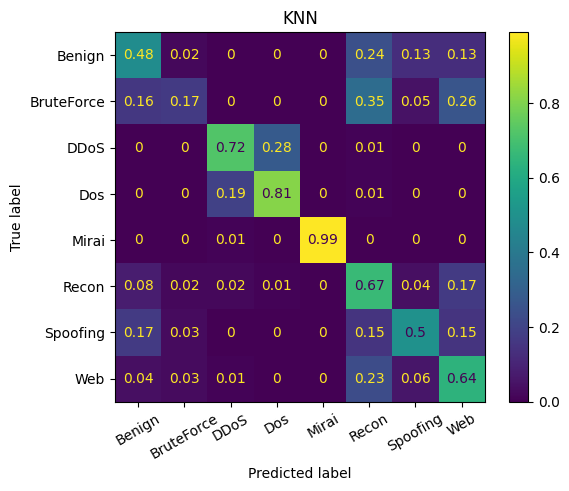

In [77]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 8, "KNN")
pickle_save(knn, "knn_8")

              precision    recall  f1-score   support

      Benign      0.541     0.523     0.532       327
  BruteForce      0.511     0.197     0.284       122
        DDoS      0.922     0.671     0.777      4150
         DoS      0.460     0.831     0.592      1361
       Mirai      0.998     0.993     0.995       938
       Recon      0.634     0.701     0.666       835
    Spoofing      0.674     0.571     0.618       471
         Web      0.555     0.659     0.603       558

    accuracy                          0.715      8762
   macro avg      0.662     0.643     0.633      8762
weighted avg      0.774     0.715     0.725      8762

Model saved to rfc_8


<Figure size 1200x600 with 0 Axes>

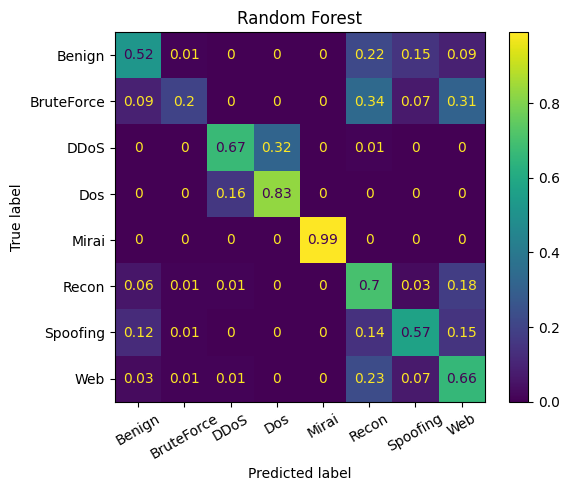

In [78]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 8, "Random Forest")
pickle_save(rfc, "rfc_8")

In [79]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv(f'{output_path}/metrics_8.csv', index=True)
metrics_8

,Logistic Regression,KNN,Random Forest
Accuracy,0.689112,0.721182,0.715019
Recall,0.483468,0.619998,0.643219
Precision,0.573805,0.620351,0.661863
F1-Score,0.485366,0.609974,0.633391


### 34 Classes

In [80]:
# df34_feat = pd.read_csv('/kaggle/working/pca_transformed_data.csv')
# df34_feat['label']=df34['label']
# df_processed = pd.DataFrame(pipeline.fit_transform(df34))
df_processed['label']=label34
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
print(y_test.value_counts())
target_names = list(y_test.unique())

label
DDoS-ICMP_Flood            484
DDoS-UDP_Flood             456
DDoS-TCP_Flood             438
DDoS-SYN_Flood             432
DDoS-RSTFINFlood           432
DDoS-PSHACK_Flood          432
DDoS-SynonymousIP_Flood    418
DoS-UDP_Flood              412
DoS-TCP_Flood              395
DoS-SYN_Flood              371
BenignTraffic              328
Mirai-greeth_flood         322
Mirai-udpplain             313
Mirai-greip_flood          303
DDoS-ICMP_Fragmentation    272
MITM-ArpSpoofing           248
DDoS-ACK_Fragmentation     246
DDoS-UDP_Fragmentation     246
DNS_Spoofing               223
Recon-HostDiscovery        207
Recon-OSScan               198
Recon-PortScan             189
DoS-HTTP_Flood             182
VulnerabilityScan          160
DDoS-HTTP_Flood            151
DDoS-SlowLoris             143
DictionaryBruteForce       122
BrowserHijacking           104
CommandInjection           101
SqlInjection               100
XSS                         91
Backdoor_Malware            86
Re

In [81]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 34, "Logistic Regression")
pickle_save(logreg_model, "logreg_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.300     0.070     0.113        86
          BenignTraffic      0.424     0.655     0.515       328
       BrowserHijacking      0.462     0.058     0.103       104
       CommandInjection      0.529     0.178     0.267       101
 DDoS-ACK_Fragmentation      0.871     0.984     0.924       246
        DDoS-HTTP_Flood      0.647     0.728     0.685       151
        DDoS-ICMP_Flood      0.992     1.000     0.996       484
DDoS-ICMP_Fragmentation      0.915     0.993     0.952       272
      DDoS-PSHACK_Flood      0.993     1.000     0.997       432
       DDoS-RSTFINFlood      1.000     0.998     0.999       432
         DDoS-SYN_Flood      0.554     0.944     0.699       432
         DDoS-SlowLoris      0.339     0.406     0.369       143
DDoS-SynonymousIP_Flood      0.655     0.682     0.668       418
         DDoS-TCP_Flood      0.538     0.950     0.687       438
         DDoS-UDP_Flood 

In [82]:
knn = KNeighborsClassifier(n_neighbors = 34)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 34, "KNN")
pickle_save(knn, "knn_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.227     0.116     0.154        86
          BenignTraffic      0.378     0.668     0.482       328
       BrowserHijacking      0.152     0.135     0.143       104
       CommandInjection      0.289     0.257     0.272       101
 DDoS-ACK_Fragmentation      0.937     0.959     0.948       246
        DDoS-HTTP_Flood      0.704     0.755     0.728       151
        DDoS-ICMP_Flood      0.982     0.994     0.988       484
DDoS-ICMP_Fragmentation      0.957     0.985     0.971       272
      DDoS-PSHACK_Flood      0.955     0.993     0.974       432
       DDoS-RSTFINFlood      0.993     0.995     0.994       432
         DDoS-SYN_Flood      0.594     0.938     0.727       432
         DDoS-SlowLoris      0.640     0.671     0.655       143
DDoS-SynonymousIP_Flood      0.703     0.684     0.693       418
         DDoS-TCP_Flood      0.531     0.856     0.656       438
         DDoS-UDP_Flood 

In [83]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 34, "Random Forest")
pickle_save(rfc, "rfc_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.333     0.244     0.282        86
          BenignTraffic      0.451     0.640     0.529       328
       BrowserHijacking      0.233     0.163     0.192       104
       CommandInjection      0.298     0.248     0.270       101
 DDoS-ACK_Fragmentation      0.984     0.988     0.986       246
        DDoS-HTTP_Flood      0.842     0.775     0.807       151
        DDoS-ICMP_Flood      0.998     1.000     0.999       484
DDoS-ICMP_Fragmentation      0.982     0.989     0.985       272
      DDoS-PSHACK_Flood      0.991     1.000     0.995       432
       DDoS-RSTFINFlood      1.000     0.998     0.999       432
         DDoS-SYN_Flood      0.432     0.259     0.324       432
         DDoS-SlowLoris      0.808     0.825     0.817       143
DDoS-SynonymousIP_Flood      0.442     0.935     0.600       418
         DDoS-TCP_Flood      0.558     0.961     0.706       438
         DDoS-UDP_Flood 

In [84]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv(f'{output_path}/metrics_34.csv', index=True)
metrics_34

,Logistic Regression,KNN,Random Forest
Accuracy,0.626227,0.682493,0.66058
Recall,0.510302,0.577199,0.583994
Precision,0.524659,0.589521,0.605996
F1-Score,0.487391,0.570205,0.572476


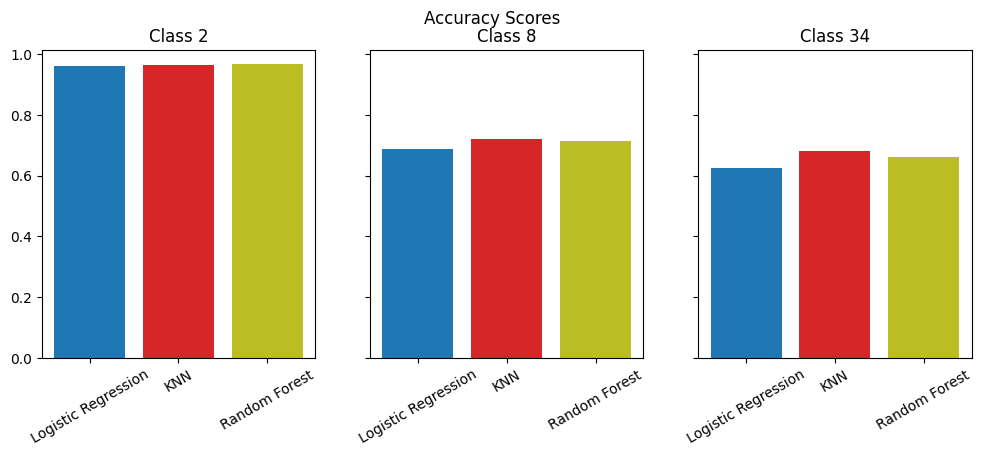

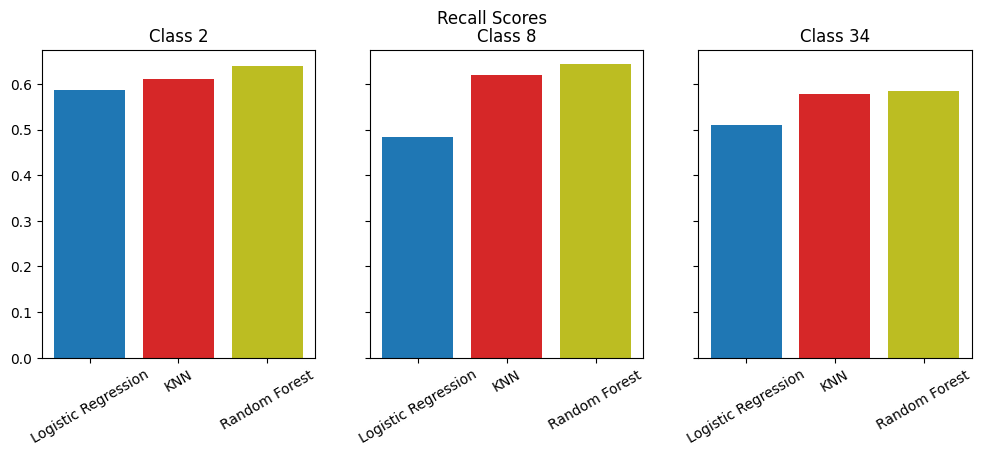

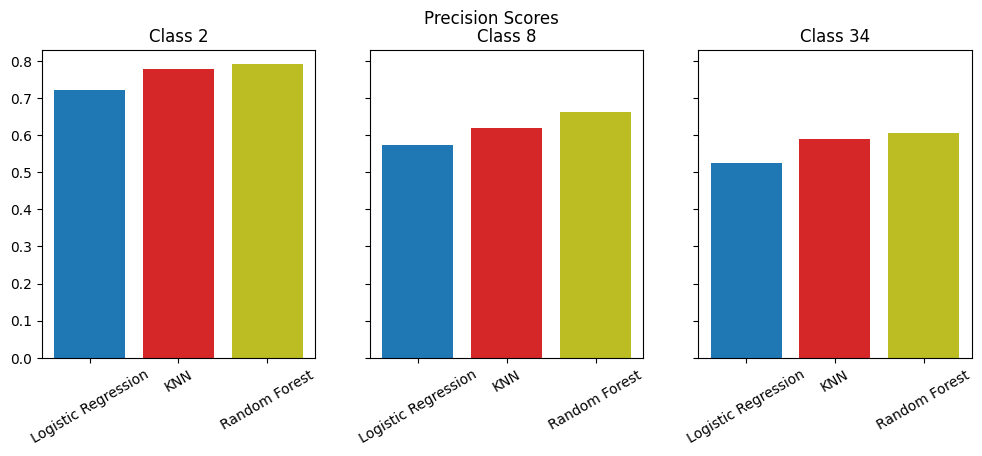

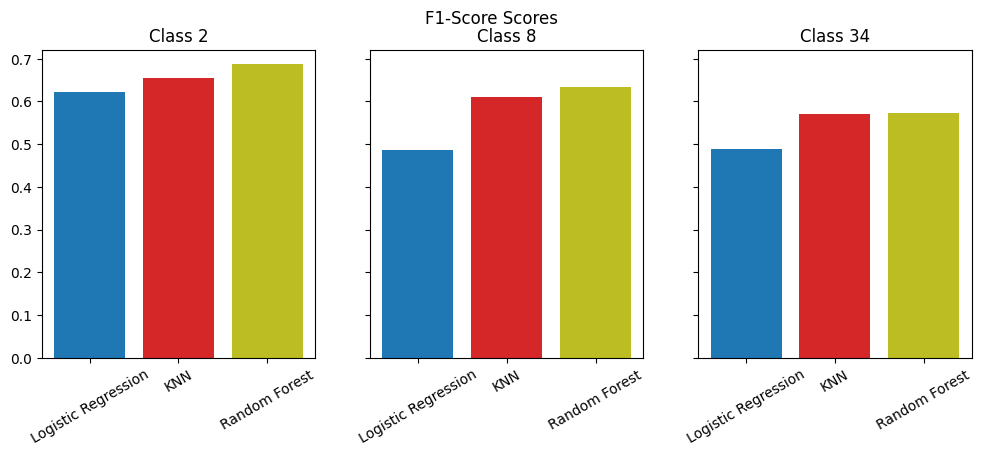

In [85]:
# List of model names
model_names = ["Logistic Regression", "KNN", "Random Forest"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "KNN": 'tab:red',
    "Random Forest": 'tab:olive',
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(12, 4), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")

        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)

        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=30)

    # Save the figure
    plt.savefig(f'{output_path}/{metric}_scores.png', bbox_inches='tight')

    plt.show()

# Efficient Intrution Detection
In real-world application, it requires that the detection will be effective as well as efficient.
One scenario will be analyzed: how models trained in smaller percentage of data perform on larger percentage of data. Though some degree of performance downgrade is observed, the models can stil function and some interesitng findings here:


*   Random Forest perform better for high-density data and worse on low-density ones. The reason behind is likely its tendency of overfitting despite of ensembling the average output of decision tree.
*   KNN perform just the opposite due to its nature to aggregate the local neighbours.




## Evaluation of Models Trained on Smaller Data Subsets Applied to Larger Datasets

column of high correlation(0.9) to be dropped: [10, 25, 29, 30, 31, 33, 34, 37, 38]
Model loaded from models/rfc_8.pkl
              precision    recall  f1-score   support

      Benign      0.564     0.415     0.478      1704
  BruteForce      0.545     0.035     0.065       691
        DDoS      0.784     0.937     0.854     21541
         DoS      0.620     0.254     0.360      7079
       Mirai      0.996     0.983     0.989      4881
       Recon      0.504     0.781     0.613      4455
    Spoofing      0.626     0.561     0.592      2498
         Web      0.559     0.366     0.442      3030

    accuracy                          0.730     45879
   macro avg      0.650     0.541     0.549     45879
weighted avg      0.719     0.730     0.701     45879

Model loaded from models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.424     0.462     0.442      1704
  BruteForce      0.190     0.110     0.139       691
        DDoS      0.725     0.69

<Figure size 1200x600 with 0 Axes>

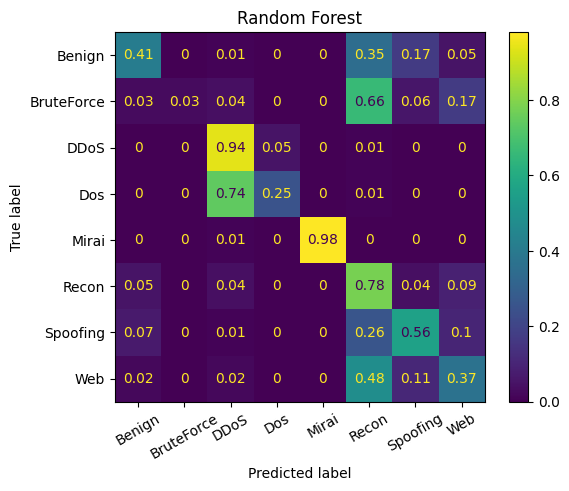

<Figure size 1200x600 with 0 Axes>

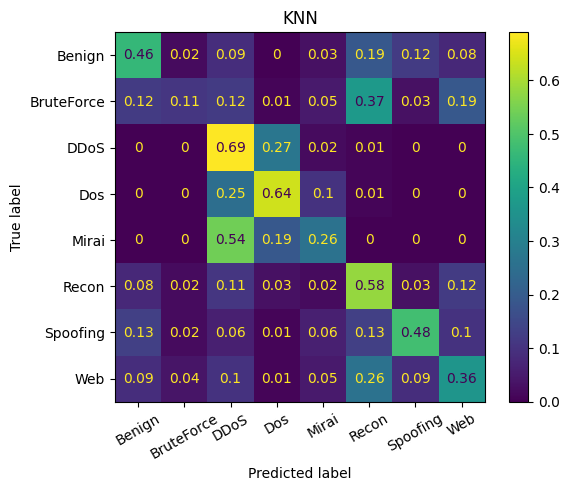

In [86]:
# test model on larger percentage
label8 = df8_s["label"]
df8 = df8_s.drop(["label"],axis=1)

# Convert NumPy array to DataFrame
df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label'] = label8
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

column of high correlation(0.9) to be dropped: [10, 25, 29, 30, 31, 33, 34, 37, 38]
Model loaded from models/rfc_8.pkl
              precision    recall  f1-score   support

      Benign      0.564     0.416     0.479      3425
  BruteForce      0.538     0.030     0.057      1401
        DDoS      0.806     0.867     0.836     43287
         DoS      0.504     0.371     0.427     14227
       Mirai      0.997     0.990     0.993      9813
       Recon      0.528     0.796     0.635      8568
    Spoofing      0.688     0.570     0.624      5029
         Web      0.509     0.436     0.469      4866

    accuracy                          0.726     90616
   macro avg      0.642     0.559     0.565     90616
weighted avg      0.717     0.726     0.713     90616

Model loaded from models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.429     0.512     0.467      3425
  BruteForce      0.228     0.126     0.163      1401
        DDoS      0.856     0.77

<Figure size 1200x600 with 0 Axes>

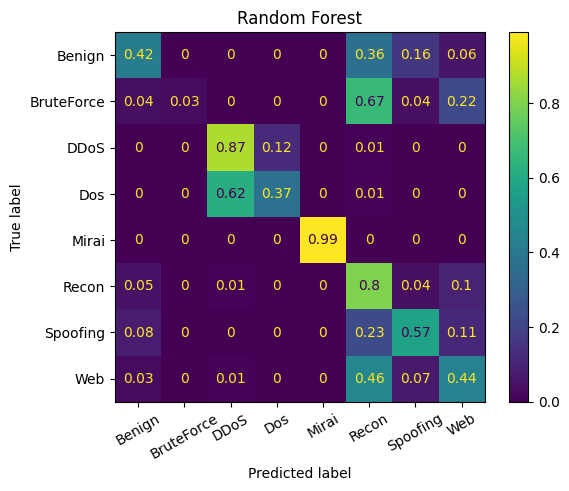

<Figure size 1200x600 with 0 Axes>

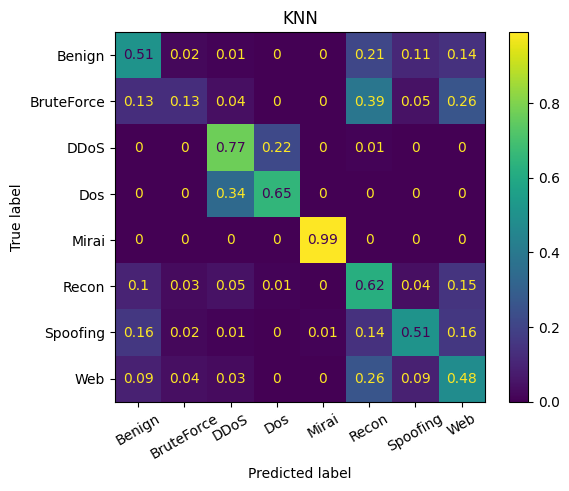

In [87]:
# extract the label value
label8 = df8_m["label"]
df8 = df8_m.drop(["label"],axis=1)

# Convert NumPy array to DataFrame
df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label'] = label8
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

### Autoencoder
If time permitted, autoencoder will be used to compare the effect of differentiating benign/malicious traffic with classical models.

In [88]:
!pip install tensorflow
!pip install tensorflow_model_optimization
!pip install keras
!pip install optuna

import optuna

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns]:
    print(f"Using {lib.__name__} {lib.__version__}")

RANDOM_SEED = 5
PATH_TO_QAE_CLASS = "../../Quantized Autoencoders (QAE)/Final Versions"
tf.random.set_seed(RANDOM_SEED)
"""
# Import the QAE class
sys.path.append(os.path.abspath(PATH_TO_QAE_CLASS))
from QAE import QAE
print("INFO: QAE class successfully imported.")
"""

class QAE:
    """
    Creates a Quantized Autoencoder (QAE) for anomaly detection from a dataset composed of X_preprocessed and y.
    Note that the "y" series has no importance on its own: we only use it to make the train-test split,
    but in principle all your values in y should have the same label as you want anomaly detection,
    not classification.

    Last modification on the 8th of August 2024 by Alexandre Le Mercier.
    """
    def __init__(self, X_preprocessed, y, random_seed=5, test_size:float=0.3, first_layer:int=128,
                 verbose:bool=True, activation:str='relu', loss:str='mean_squared_error', optimizer:str='adam',
                 epochs:int=50, batch_size:int=32, shuffle:bool=True, figures_path:str="", name:str="autoencoder",
                 pruning_initial_sparsity:float=0.2, pruning_final_sparsity:float=0.8, pruning_begin_step:int=0,
                 pruning_end_step_divider:int=32*10, pruning_epochs:int=10, pruning_batch_size:int=32,
                 number_of_clusters:int=8, models_path:str="", cluster_epochs:int=10, cluster_batch_size:int=32,
                 use_regularization:bool=True, regularization_weights:float=0.001,threshold:float=None):

        self.F1_score = None
        self.recall = None
        self.precision = None
        self.accuracy = None
        self.confusion_matrix = None
        self.model_for_export = None
        self.history = None
        self.y_val = None
        self.y_train = None
        self.X_val = None
        self.X_train = None
        self.input_dim = None
        self.autoencoder = None
        self.pruning_end_step = None

        self.X_preprocessed = X_preprocessed
        self.y = y
        self.seed = random_seed
        self.test_size = test_size
        self.first_layer = first_layer
        self.verbose = verbose
        self.activation = activation
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.figures_path = figures_path
        self.name = name
        self.pruning_initial_sparsity = pruning_initial_sparsity
        self.pruning_final_sparsity = pruning_final_sparsity
        self.pruning_begin_step = pruning_begin_step
        self.pruning_end_step_divider = pruning_end_step_divider
        self.pruning_epochs = pruning_epochs
        self.pruning_batch_size = pruning_batch_size
        self.number_of_clusters = number_of_clusters
        self.models_path = models_path
        self.cluster_epochs = cluster_epochs
        self.cluster_batch_size = cluster_batch_size
        self.use_regularization = use_regularization
        self.regularization_weights = regularization_weights
        self.threshold = threshold

        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        #assert tf.__version__ == "2.13.0", 'TensorFlow 2.13 required for compatibility with tfmot 0.8.0.'
        assert self.first_layer % 8 == 0, 'The specified layer number is not dividable by 8.'

        self.verbose_message(f"QAE INFO: Bottleneck layer will be made of {self.first_layer//8} neurons.")

        self.split_data()
        self.create_autoencoder_model()
        self.compile_autoencoder()

        self.verbose_message("QAE model successfully created. Execute self.train_autoencoder() when ready.")

    def split_data(self):
        self.X_train, self.X_val, _, _ = train_test_split(self.X_preprocessed,
                                                          self.y, test_size=self.test_size,
                                                          random_state=self.seed)
        self.input_dim = self.X_train.shape[1]
        self.pruning_end_step =  len(self.X_train) // self.pruning_end_step_divider

    def create_autoencoder_model(self):
        # Function to optionally add regularizer
        def add_dense_layer(units):
            return layers.Dense(units, activation=self.activation,
                                kernel_regularizer=regularizers.l2(self.regularization_weights) if self.use_regularization else None)

        layers_list = [
            add_dense_layer(self.first_layer),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 8),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer),
            layers.Dense(self.input_dim, activation='sigmoid')
        ]

        self.autoencoder = Sequential(layers_list)
        self.autoencoder.build(input_shape=(None, self.input_dim))

    def compile_autoencoder(self):
        self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)
        if self.verbose:
            self.autoencoder.summary()

    def train_autoencoder(self):
        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                                            epochs=self.epochs,
                                            batch_size=self.batch_size,
                                            shuffle=self.shuffle,
                                            verbose=self.verbose,
                                            validation_data=(self.X_val, self.X_val))
        if self.verbose:
            self.plot_learning_curves()
        self.save_model(self.autoencoder, f"{self.name}_model")
        self.model_for_export = self.autoencoder
        self.verbose_message("QAE model successfully trained. Execute self.quantize_autoencoder()"
                             " or self.prune_and_cluster_autoencoder() when ready.")

    def plot_learning_curves(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.figures_path + "QAE_learning_curves.png")
        plt.show()


    def representative_data_gen(self):
        for input_value in tf.data.Dataset.from_tensor_slices(self.X_train).batch(1).take(100):
            yield [tf.cast(input_value, tf.float32)]

    def quantize_parameters_and_activation_functions(self, model, name=None):
        if name is None:
            name = f"{self.name}_int_quant_model"
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_int_quant_model = converter.convert()
        self.save_model(tflite_int_quant_model, name, '.tflite')

    def quantize_autoencoder(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.autoencoder)
        tflite_model = converter.convert()
        self.save_model(tflite_model, f'{self.name}_model', '.tflite')
        self.quantize_parameters_and_activation_functions(self.autoencoder)

    def prune_and_cluster_autoencoder(self):
        self.prune_autoencoder()
        self.cluster_autoencoder()

    def prune_autoencoder(self, quant=True):
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=self.pruning_initial_sparsity,
                final_sparsity=self.pruning_final_sparsity,
                begin_step=self.pruning_begin_step,
                end_step=self.pruning_end_step
            )
        }
        config = self.autoencoder.get_config()
        weights = self.autoencoder.get_weights()
        self.autoencoder = keras.models.Sequential.from_config(config)
        self.autoencoder.set_weights(weights)
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(self.autoencoder, **pruning_params)
        pruned_model.compile(optimizer=self.optimizer, loss=self.loss)
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
        pruned_model.fit(self.X_train, self.X_train,
                         epochs=self.pruning_epochs,
                         batch_size=self.pruning_batch_size,
                         validation_data=(self.X_val, self.X_val),
                         verbose=self.verbose,
                         callbacks=callbacks)
        self.model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
        self.save_model(self.model_for_export, f'pruned_{self.name}_model')
        if quant is True:
            self.quantize_parameters_and_activation_functions(self.model_for_export, f"{self.name}_pruned_model")
        else:
            self.save_model(self.model_for_export, f"{self.name}_pruned_model", '.keras')

    def cluster_autoencoder(self, quant=True, use_pruned_model=False):
        clustering_params = {
            'number_of_clusters': self.number_of_clusters,
            'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
        }
        if use_pruned_model:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.model_for_export, **clustering_params)
        else:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.autoencoder, **clustering_params)
        clustered_model.compile(optimizer='adam', loss='mean_squared_error')
        clustered_model.fit(self.X_train, self.X_train,
                            epochs=self.cluster_epochs,
                            batch_size=self.cluster_batch_size,
                            validation_data=(self.X_val, self.X_val))
        final_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)
        self.save_model(final_clustered_model, f'clustered_{self.name}_model')
        if quant:
            self.quantize_parameters_and_activation_functions(final_clustered_model, f'{self.name}_clustered_model')
        else:
            self.save_model(final_clustered_model, f"{self.name}_clustered_model", '.keras')

    def test_on_validation_set(self, path_to_model, X_benign_val_preprocessed=None, X_anomaly_preprocessed=None,
                               percentage_false_negatives: float = 0.05, automatic_threshold: bool = False, silence=False,
                               manual_threshold=None, anomaly_if="higher"):
        # Load the model
        autoencoder = tf.keras.models.load_model(path_to_model)

        # Plotting function remains unchanged
        def plot_reconstruction_error_boxplot(reconstruction_error, threshold, title):
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=reconstruction_error, color='blue')
            plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}')
            plt.title(title)
            plt.xlabel('Reconstruction Error')
            plt.legend()
            plt.xlim([0, np.percentile(reconstruction_error, 99)])
            plt.show()

        # Calculate the threshold based on the training data
        X_benign_train_reconstructed = autoencoder.predict(self.X_preprocessed)
        reconstruction_error_train = tf.keras.losses.mean_squared_error(self.X_preprocessed, X_benign_train_reconstructed).numpy()

        if self.threshold is not None:
            threshold = self.threshold
        elif automatic_threshold:
            threshold = np.mean(reconstruction_error_train) + np.std(reconstruction_error_train)
        elif manual_threshold is not None:
            threshold = manual_threshold
        else:
            threshold = np.percentile(reconstruction_error_train, 100 * (1.0 - percentage_false_negatives))

        self.threshold = threshold

        # Plot boxplot for training data
        if not silence:
            plot_reconstruction_error_boxplot(reconstruction_error_train, threshold, title='RE Boxplot on Training Data')

        if X_anomaly_preprocessed is None and X_benign_val_preprocessed is None:
            sets = []
        elif X_anomaly_preprocessed is None:
            sets = [(X_benign_val_preprocessed, 'Validation Benign Data')]
        else:
            sets = [(X_anomaly_preprocessed, 'Malicious Data'), (X_benign_val_preprocessed, 'Validation Benign Data')]

        # Initialize confusion matrix components
        TP = FP = TN = FN = 0

        for X, description in sets:
            X_reconstructed = autoencoder.predict(X)
            reconstruction_error = tf.keras.losses.mean_squared_error(X, X_reconstructed).numpy()

            # Plot boxplot for validation sets
            if not silence:
                plot_reconstruction_error_boxplot(reconstruction_error, threshold, title=f'RE Boxplot on {description}')

            # Check for anomalies based on reconstruction error
            if anomaly_if == "higher":
                anomalies = reconstruction_error > threshold
            elif anomaly_if == "lower":
                anomalies = reconstruction_error < threshold
            else:
                print("'anomaly_if'  be either 'higher' or 'lower'.")
                return

            # Calculate TP, FP, TN, FN based on description
            if description == 'Validation Benign Data':
                TN += np.sum(~anomalies)  # True Negatives: Benign correctly identified
                FP += np.sum(anomalies)   # False Positives: Benign incorrectly identified as anomaly
            elif description == 'Malicious Data':
                TP += np.sum(anomalies)   # True Positives: Malicious correctly identified as anomaly
                FN += np.sum(~anomalies)  # False Negatives: Malicious incorrectly identified as benign

        if X_anomaly_preprocessed is not None and X_benign_val_preprocessed is not None:
            self.accuracy = (TP + TN) / (TP + FP + TN + FN)
            self.precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            self.recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            self.F1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall) if (self.precision + self.recall) > 0 else 0
            self.confusion_matrix = [
                [TN, FP],
                [FN, TP]
            ]

            if not silence:
                print("Accuracy:", self.accuracy)
                print("Precision:", self.precision)
                print("Recall:", self.recall)
                print("F1 score:", self.F1_score)
                print("Confusion matrix:", self.confusion_matrix)


        # Plotting distribution of reconstruction errors
        """
        if not silence:
            plt.figure(figsize=(12,8))
            sns.set(font_scale=2)
            sns.set_style("white")
            sns.histplot(reconstruction_error_train, bins=50, kde=True, color='grey', linewidth=3, label='Train Loss')
            plt.axvline(x=np.mean(reconstruction_error_train), color='g', linestyle='--', linewidth=3)
            plt.text(np.mean(reconstruction_error_train), 200, "Normal Mean", horizontalalignment='center',
                     size='small', color='black', weight='semibold')
            plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
            plt.text(threshold, 250, "Threshold", horizontalalignment='center',
                     size='small', color='blue', weight='semibold')

            for i, loss in enumerate(test_loss):
                color = 'red' if i == 0 else 'blue'
                label = 'Test Loss' if i == 0 else 'Validation Loss'
                sns.histplot(loss, bins=50, kde=True, color=color, linewidth=3, label=label)
                plt.axvline(x=np.mean(loss), color='g', linestyle='--', linewidth=3)
                plt.text(np.mean(loss), 200, f"{label} Mean", horizontalalignment='center',
                         size='small', color='black', weight='semibold')
                plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

            plt.xlabel("Loss")
            plt.ylabel("Number of Examples")
            plt.legend()
            sns.despine()
            plt.show()
        """

    def verbose_message(self, message):
        if self.verbose:
            print(message)

    def save_model(self, model, name, ext='.keras'):
        if ext == ".keras" or ext == ".h5":
            model.save(self.models_path + name + ext)
        elif ext == ".tflite":
            with open(self.models_path + name + ext, 'wb') as f:
                f.write(model)
        self.verbose_message(f"Model {self.models_path + name + ext} saved. "
                             f"Size: {os.path.getsize(self.models_path + name + ext) / 1024} KB")

Using pandas 2.2.2
Using sklearn 1.5.2
Using seaborn 0.13.2


In [89]:
# Choosing the threshold visually
best_params = {
    'name': "best_optuna_ben050.0_mal000.1_qae",
    'first_layer': 288, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 112, 'regularization_weights': 0.004035483817578062,
    'epochs': 20,
    'use_regularization': True
}
params = {
        'name': "Models/final_opt_qae",
        'first_layer': best_params['first_layer'],
        'activation': best_params['activation'],
        'optimizer': best_params['optimizer'],
        'batch_size': best_params['batch_size'],
        'regularization_weights': best_params['regularization_weights'],
        'epochs': 20,
        'use_regularization': True
}

#lim = 1000000
# qae = QAE(benign_df_tr, pd.Series(["is_benign"]*benign_df_tr.shape[0]), **params)
# qae.threshold=150
# qae.train_autoencoder()

## Potential integration with IPS(Intrusion Prevention System)
In Kaggle community, there are existing feature importance analysis based on different model. Meanwhile, there exists many fine-tuning framework in the market, such as Optuna, which can find the best parameter for identifying attack traffic in accuracy. Combined with these efforts, it is promising an automatic threshold setting   on configurable parameter of IPS, such as Suricata, will be able to adaptively block the intrusion attempt.

*This can be good research topic for future.*